# Reload & Explore Local NWB Data

In [1]:
%config Completer.use_jedi = False

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from pynwb import NWBHDF5IO

## Load File

In [3]:
# Read in an local data NWB file
io = NWBHDF5IO('nwb_local_data.nwb', 'r')
nwbfile = io.read()

In [4]:
nwbfile

root pynwb.file.NWBFile at 0x140205917087728
Fields:
  acquisition: {
    field_data <class 'pynwb.ecephys.ElectricalSeries'>,
    position <class 'pynwb.behavior.Position'>
  }
  devices: {
    RECORDING DEVICE <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    A-microwires-chnum <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  experiment_description: Example conversion to NWB format.
  experimenter: ['XX']
  file_create_date: [datetime.datetime(2021, 3, 30, 11, 2, 43, 504488, tzinfo=tzoffset(None, -14400))]
  identifier: XX
  institution: Columbia
  intervals: {
    trials <class 'pynwb.epoch.TimeIntervals'>
  }
  lab: U01 Group
  processing: {
    position_measures <class 'pynwb.base.ProcessingModule'>
  }
  session_description: XX
  session_id: 001
  session_start_time: 2021-03-30 11:02:43.503626-04:00
  stimulus: {
    chest_positions <class 'pynwb.base.TimeSeries'>
  }
  subject: subject pynwb.file.Subject at 

## Units Data

In [5]:
nwbfile.units

units pynwb.misc.Units at 0x140205917494864
Fields:
  colnames: ['spike_times' 'electrodes' 'waveform_mean']
  columns: (
    spike_times_index <class 'hdmf.common.table.VectorIndex'>,
    spike_times <class 'hdmf.common.table.VectorData'>,
    electrodes_index <class 'hdmf.common.table.VectorIndex'>,
    electrodes <class 'hdmf.common.table.DynamicTableRegion'>,
    waveform_mean <class 'hdmf.common.table.VectorData'>
  )
  description: Autogenerated by NWBFile
  id: id <class 'hdmf.common.table.ElementIdentifiers'>
  waveform_unit: volts

In [6]:
# Pull out all the spike times from NWB file
spike_times = nwbfile.units.spike_times

In [7]:
# Check the total number of spikes
print('Total number of spikes: {}'.format(spike_times.shape[0]))

Total number of spikes: 183661


#### Check Unit of Interest

In [8]:
# Set index
uind = 0

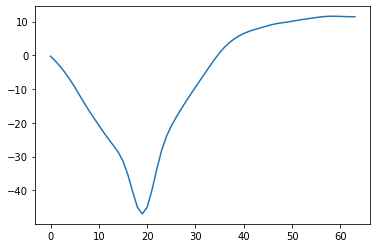

In [9]:
# Plot waveform from unit of interest
plt.plot(nwbfile.units['waveform_mean'][uind, :])

In [10]:
# Grab spikes for requested unit
u0_spikes = nwbfile.units.get_unit_spike_times(uind)
print(u0_spikes[0:3])

[ 1139.93713312 15112.58370861 15118.71706239]


## Example Spatial Firing Analysis

In [11]:
def get_spike_time_range(spikes, tmin, tmax):
    """Extract spike times for a particular time range."""
    
    return spikes[np.squeeze(np.logical_and([spikes > tmin], [spikes < tmax]))]


def get_spike_pos(spikes, pos):
    """Get spike activity for specific locations.
    
    spikes : xx
    pos : xx
    """

    xs = pos.data[0, :]
    ys = pos.data[1, :]
    
    x_counts, x_bins = np.histogram(xs, bins=15)
    y_counts, y_bins = np.histogram(ys, bins=10)
    
    n_xbins = len(x_bins)-1
    n_ybins = len(y_bins)-1

    out = np.zeros([n_xbins, n_ybins])
    
    for xbin_ind in range(n_xbins):

        in_xbin = np.logical_and(xs > x_bins[xbin_ind], xs < x_bins[xbin_ind + 1])
        
        for ybin_ind in range(n_ybins):
            
            in_ybin = np.logical_and(ys > y_bins[ybin_ind], ys < y_bins[ybin_ind + 1])
            
            in_bin = np.logical_and(in_xbin, in_ybin)
                
            wheres = np.where(np.diff(in_bin))[0]

            bin_spikes = 0
            bin_time = 0    
            for ind in wheres[:-1]:

                t_start = pos.timestamps[ind]
                t_stop = pos.timestamps[ind + 1]

                bin_spikes += len(get_spike_time_range(spikes, t_start, t_stop))
                bin_time += (t_stop - t_start) / 1000
            
            if bin_time != 0:
                #print('A', bin_spikes, '\tB', bin_time)
                out[xbin_ind, ybin_ind] = bin_spikes / bin_time
                
    out[out == 0.] = np.nan
    
    return out

In [12]:
# Check the position data store
nwbfile.acquisition['position']

position pynwb.behavior.Position at 0x140205917492320
Fields:
  spatial_series: {
    xy_pos <class 'pynwb.behavior.SpatialSeries'>
  }

In [13]:
# Grab the position data
pos = nwbfile.acquisition['position']['xy_pos']

### Anlyze Unit of Interest

In [14]:
# Set index for unit of interest
s_ind = 5

In [15]:
# Get spikes for unit of interest
spikes = nwbfile.units.get_unit_spike_times(s_ind)

In [16]:
# Get the mapping of spike rate across positions
arr = get_spike_pos(spikes, pos)

In [17]:
print('Min / Max Firing Rate: {:1.2f}, {:1.2f}'.format(np.nanmin(arr), np.nanmax(arr)))
print(np.nanmedian(arr))
print(np.nanmean(arr))

Min / Max Firing Rate: 1.29, 10.91
3.439732267869471
3.8795048611232543


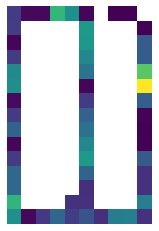

In [18]:
plt.imshow(arr)
plt.axis('off');

### Run Analysis Across all units

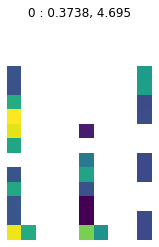

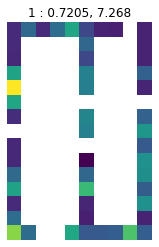

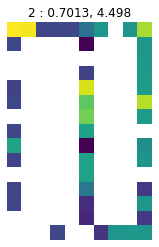

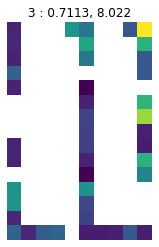

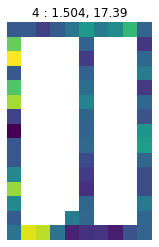

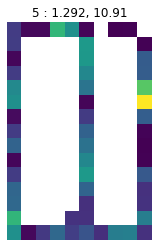

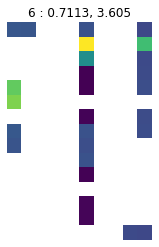

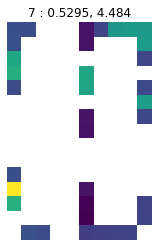

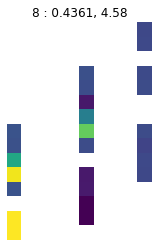

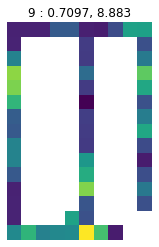

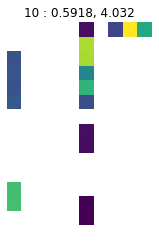

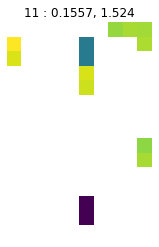

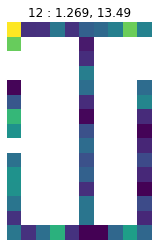

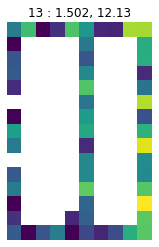

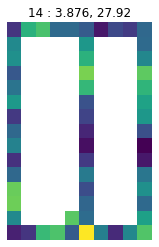

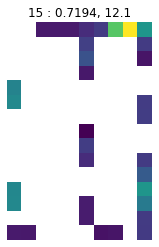

In [19]:
for s_ind in range(len(nwbfile.units)):
    spikes = nwbfile.units.get_unit_spike_times(s_ind)
    arr = get_spike_pos(spikes, pos)
    plt.figure()
    plt.imshow(arr)
    plt.axis('off');
    plt.title('{} : {:1.4}, {:1.4}'.format(s_ind, np.nanmin(arr), np.nanmax(arr)))